# Camera Pose Estimation
This notebook contains ...

[paper by Shotton et al.](https://www.microsoft.com/en-us/research/publication/scene-coordinate-regression-forests-for-camera-relocalization-in-rgb-d-images/) [1]

In [1]:
# We can not provide a full package yet
# and load our python files manually
import sys
sys.path.append('./source/')

***
## 1. Data Loading
In order to get started we first need to download data from the [**7-scenes dataset**](https://www.microsoft.com/en-us/research/project/rgb-d-dataset-7-scenes/). Therefore, just hop into the **/data** folder where you will find a notebook called **load_and_clean_7_scenes_dataset.ipynb**. Just pick a scene of your choice and execute the corresponding cell. 

To get an intuition for the data, we plot a number of `SAMPLES` of random images and corresponding depth maps from the data set `SCENE`. Additionally, the full volumetric image of the scene is displayed.

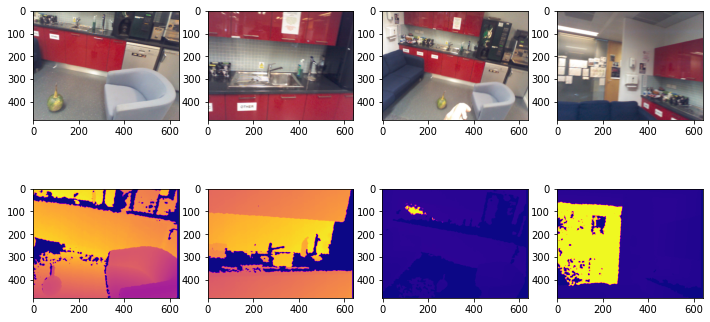

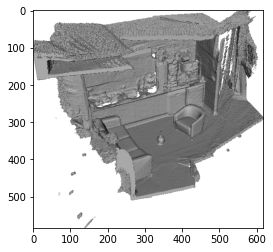

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from source.data_loader import DataLoader 

SCENE = "heads"
DATA_PATH = "./data"
SAMPLES = 4

loader = DataLoader(DATA_PATH)
indices = np.random.choice(loader.get_dataset_length(SCENE), SAMPLES, replace = False)
images, depths, poses = loader.load_dataset(SCENE, indices)

# plot random images 
_, axes = plt.subplots(2, SAMPLES, figsize=(12,6))
for i in range(SAMPLES):
    axes[0,i].imshow(np.swapaxes(images[i], 1, 0))
    axes[1,i].imshow(depths[i].T, cmap=plt.get_cmap("plasma"))
plt.show()

# plot volume
full_scene = np.array(Image.open(f"./data/{SCENE}/{SCENE}.png"))
plt.imshow(full_scene)

***
## 2. Regression Forest

### 2.1 Training
To train a forest for a certain scene we provide the script **/source/train_forest.py**. Initially, all hyperparameters must be set and are displayed in the following table:

| Hyperparameter | Value        | 
| ------------- |:-------------:| 
|TEST_SIZE | *0.5* |
|NUM_TREES | 5 |
|TREE_MAX_DEPTH | 16 |
|NUM_TRAIN_IMAGES_PER_TREE | 500 |
|NUM_SAMPLES_PER_IMAGE | 5000   |
|NUM_PARAMETER_SAMPLES | 1024 |
|FEATURE_TYPE | *DA_RGB / DEPTH* |

We chose all hyperparameters according to the values stated in section 4.4 and Table 1 of [1]. Make sure to  adjust the test size for each dataset since the values vary. Subsequently, the dataset is loaded and split into training and test data. The forest is initialized and the training process started. When the training is finished, the forest object and corresponding parameters are saved. 

Here, we load a trained forest

In [17]:
import os
from source.utils import load_object, millis

OUTPUT = "./output"
PREFIX = "23-03-2022_18-56_pumpkin"

params = load_object(os.path.join(OUTPUT, PREFIX, f"params_{SCENE}.pkl"))
print(f'Loading forest trained on "{SCENE}"')

[print(f'\t{key}: {params[key]}') for key in [
    'TIMESTAMP',
    'TREE_MAX_DEPTH',
    'NUM_TREES',
    'NUM_TRAIN_IMAGES_PER_TREE',
    'NUM_SAMPLES_PER_IMAGE',
    'NUM_PARAMETER_SAMPLES',
    'FEATURE_TYPE']]
    
forest = load_object(os.path.join(OUTPUT, PREFIX, f"trained_forest_{SCENE}.pkl"))

Loading forest trained on "pumpkin"
	TIMESTAMP: 23-03-2022_18-56
	TREE_MAX_DEPTH: 16
	NUM_TREES: 5
	NUM_TRAIN_IMAGES_PER_TREE: 500
	NUM_SAMPLES_PER_IMAGE: 5000
	NUM_PARAMETER_SAMPLES: 1024
	FEATURE_TYPE: FeatureType.DA_RGB


### 2.1 Testing
Now, we can use the trained forest and see how it performs on unseen data. Therefore, the forest is evaluated with randomly sampled test images. The number of test images is specified as `NUM_TEST_IMAGES` and the number of sampled pixels per image is defined as `NUM_SAMPLES_PER_IMAGE`. The resulting array contains of predictions per tree in the forest.

To 

In [18]:
NUM_TEST_IMAGES = 500
NUM_SAMPLES_PER_IMAGE = 5000

# Sample images from test data set
test_set_indices = params['TEST_INDICES']
test_indices = np.random.choice(test_set_indices, NUM_TEST_IMAGES, replace = False)
images_data = loader.load_dataset(SCENE, test_indices)

# Obtain pixel and world coordinates from sample points
p_s, w_s = loader.sample_from_data_set(
    images_data = images_data,
    num_samples = NUM_SAMPLES_PER_IMAGE)

# Evalulate forest
print(f'Evaluating Forest with {NUM_TEST_IMAGES * NUM_SAMPLES_PER_IMAGE} samples per tree...')

start = millis()
forest_predictions = forest.evaluate(p_s, images_data)

print(f'Finished after {(millis() - start):5.1F}ms')

images_data = None # free memory

Evaluating Forest with 2500000 samples per tree...
Finished after 90409.0ms


### 2.3 Evaluation
Next up, we'll show the results of our training process for the different scenes.

In [19]:
from source.evaluator import SceneCoordinateEvaluator
from source.visualization import draw_pointcloud

In [20]:
eval = SceneCoordinateEvaluator()
valid_predictions = eval.get_valid_predictions(forest_predictions)

total_num_predictions = (NUM_TEST_IMAGES * NUM_SAMPLES_PER_IMAGE * params["NUM_TREES"])
valid_num_predictions = valid_predictions.shape[0]

print(f'The forest exhibits {(valid_num_predictions / total_num_predictions):.2%} valid predictions')

The forest exhibits 91.05% valid predictions


Next up, we calculate the average deviation of the predicted 3D cooordinate with respect to the ground truth. This is calculated for each tree in the forest and as total deviation. 

Office & 2.007 \pm 1.456 \\
Stairs & 1.504 \pm 0.873 \\
RedKitchen & 1.747 \pm 1.017 \\
Chess & 1.060 \pm 0.4357 \\
Pumpkin & 1.477 \pm 0.7523 \\

Tree 1: average deviation = [1.500E+00 +/- 8.100E-01] meters
Tree 2: average deviation = [1.435E+00 +/- 6.907E-01] meters
Tree 3: average deviation = [1.644E+00 +/- 8.652E-01] meters
Tree 4: average deviation = [1.399E+00 +/- 7.450E-01] meters
Tree 5: average deviation = [1.408E+00 +/- 6.508E-01] meters

Total average deviation = [1.477E+00 +/- 7.523E-01] meters


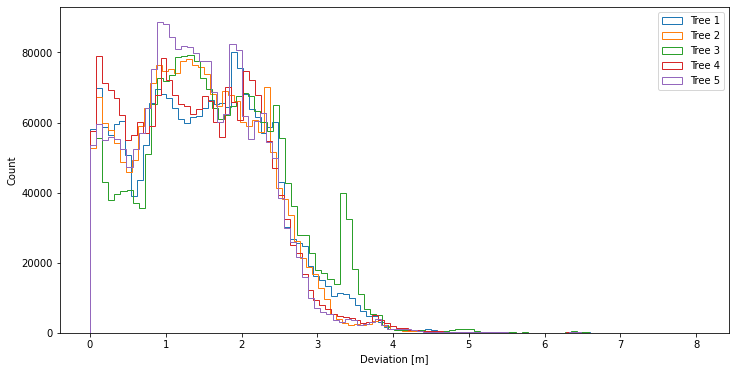

In [21]:
errors = eval.get_prediction_error(forest_predictions, w_s)

plt.figure(figsize=(12,6))
for i, err in enumerate(errors):
    plt.hist(err, bins=100, fill=False, histtype='step', label=f'Tree {i+1}')
    print(f'Tree {i+1}: average deviation = [{np.mean(err):1.3E} +/- {np.var(err):1.3E}] meters')
    
plt.xlabel('Deviation [m]')
plt.ylabel('Count')
plt.legend()

avg_deviation = np.mean([np.mean(err) for err in errors])
var_deviation = np.mean([np.var(err) for err in errors])

print(f"\nTotal average deviation = [{avg_deviation:1.3E} +/- {var_deviation:1.3E}] meters")

In [ ]:
draw_pointcloud(valid_predictions)

## 3. Predicting Camera Poses

### 3.1 Evaluation

In [19]:
from source.evaluator import PoseEvaluator
import numpy as np

pose = np.stack([np.array([ 0.82956589,  0.25454269, -0.49701957, -0.13176393]),
np.array([-0.12786476,  0.95300385,  0.27465301, -0.81012114]),
np.array([ 0.54357248, -0.16429148,  0.82312652, -0.4613063 ]),
np.array([0., 0., 0., 1.])])

gt =   np.array([[8.3529902e-001,	  2.4256018e-001,	 -4.9329793e-001,	 -1.3914277e-001],	
 [-1.2293575e-001,	  9.5704353e-001	,  2.6242670e-001	, -7.9418439e-001],	
  [5.3579146e-001,	 -1.5856197e-001,	  8.2926470e-001,	 -4.6732929e-001],	
  [0.0000000e+000	,  0.0000000e+000,	  0.0000000e+000,	  1.0000000e+000]])

eval = PoseEvaluator()
error_translation = eval.get_translational_error(np.array([pose, pose]), np.array([gt,gt]))
error_angular = eval.get_angular_error(np.array([pose, pose]), np.array([gt,gt]))
print(error_translation)
print(error_angular)

eval.evaluate(np.array([pose, pose]), np.array([gt,gt]))

[0.0185662 0.0185662]
[1.14670409 1.14670409]


1.0